In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing, model_selection

In [2]:
df = pd.read_csv("Training Data.csv")

In [3]:
df.isnull().sum()

Unnamed: 0     0
id             0
keyword       61
text           1
target         0
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])

In [6]:
y = df['target']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [8]:
X_train.shape, X_test.shape

((5285, 16513), (2266, 16513))

In [9]:
y_train.shape, y_test.shape

((5285,), (2266,))

In [10]:
X_train

<5285x16513 sparse matrix of type '<class 'numpy.int64'>'
	with 65275 stored elements in Compressed Sparse Row format>

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train_tf = tf_transformer.transform(X_train)
X_train_tf.shape

(5285, 16513)

In [12]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_test)
X_test_tf = tf_transformer.transform(X_test)
X_test_tf.shape

(2266, 16513)

# Naive Bayes Model

In [13]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [14]:
pred = clf.predict(X_test)

In [15]:
np.mean(pred == y_test)

0.8040600176522507

The Naive Bayes Model achieves 80.41% accuracy.

In [16]:
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring="f1")
scores

array([0.73246136, 0.72938444, 0.73978996, 0.76267281, 0.73341094])

In [17]:
clf_NB_TFIDF = MultinomialNB()
clf_NB_TFIDF.fit(X_train_tf, y_train)

MultinomialNB()

In [18]:
pred_tf = clf_NB_TFIDF.predict(X_test_tf)

In [19]:
np.mean(pred_tf == y_test)

0.79567519858782

In [20]:
scores = model_selection.cross_val_score(clf_NB_TFIDF, X_train_tf, y_train, cv=5, scoring="f1")
scores

array([0.68556005, 0.67371202, 0.69425901, 0.71895425, 0.68073879])

In [21]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(metrics.classification_report(y_test, pred_tf))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1302
           1       0.89      0.60      0.71       964

    accuracy                           0.80      2266
   macro avg       0.82      0.77      0.78      2266
weighted avg       0.81      0.80      0.79      2266



In [22]:
metrics.confusion_matrix(y_test, pred_tf)

array([[1228,   74],
       [ 389,  575]], dtype=int64)

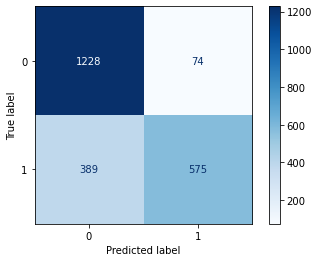

In [23]:
plot_confusion_matrix(clf_NB_TFIDF, X_test_tf, y_test, cmap='Blues')

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [26]:
params = {'alpha':(0.5, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2)}

In [27]:
cv_clf = GridSearchCV(clf, param_grid = params, cv=5, n_jobs=-1)

In [28]:
cv_clf.fit(X_train_tf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (0.5, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2)})

In [29]:
cv_clf.best_params_

{'alpha': 0.5}

In [30]:
clf_best = MultinomialNB(alpha = 0.5)
clf_best.fit(X_train_tf, y_train)
clf_best.predict(X_test_tf)

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [31]:
print("train accuracy:", clf_best.score(X_train_tf, y_train), "\n", "test accuracy:", clf_best.score(X_test_tf, y_test))

train accuracy: 0.8804162724692526 
 test accuracy: 0.8040600176522507


# SVM Model

In [32]:
from sklearn.linear_model import SGDClassifier
clfs = SGDClassifier()

clfs.fit(X_train,y_train)
predicted = clfs.predict(X_test)
np.mean(predicted == y_test)

0.7846425419240953

In [33]:
scores = model_selection.cross_val_score(clfs, X_train, y_train, cv=5, scoring='f1')
scores

array([0.71596244, 0.6960452 , 0.70833333, 0.72991071, 0.69931663])

In [34]:
clfs_tf = clfs.fit(X_train_tf, y_train)
predicted_tf = clfs_tf.predict(X_test_tf)
np.mean(predicted_tf == y_test)

0.8053839364518977

In [35]:
scores = model_selection.cross_val_score(clfs_tf, X_train_tf, y_train, cv=5, scoring='f1')
scores

array([0.72553699, 0.71648873, 0.73798077, 0.74380165, 0.72274882])

In [36]:
print(metrics.classification_report(y_test, predicted_tf))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1302
           1       0.81      0.70      0.75       964

    accuracy                           0.81      2266
   macro avg       0.81      0.79      0.80      2266
weighted avg       0.81      0.81      0.80      2266



In [37]:
metrics.confusion_matrix(y_test, predicted_tf)

array([[1148,  154],
       [ 287,  677]], dtype=int64)

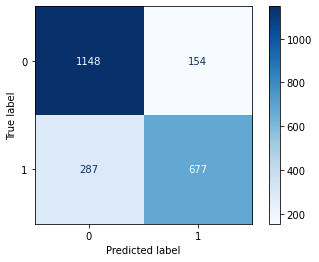

In [38]:
plot_confusion_matrix(clfs_tf, X_test_tf, y_test, cmap='Blues')

In [39]:
clfs.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [40]:
params_clfs = {'alpha' :(0.001, 0.0001)}

In [41]:
cv_clfs = GridSearchCV(clfs_tf, param_grid = params_clfs, cv=5, n_jobs=-1)

In [42]:
cv_clfs.fit(X_train_tf, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': (0.001, 0.0001)})

In [43]:
cv_clfs.best_params_

{'alpha': 0.0001}

In [44]:
clfs_best = SGDClassifier(alpha = 0.0001)
clfs_best.fit(X_train_tf, y_train)
clfs_best.predict(X_test_tf)

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [45]:
print("train accuracy:", clfs_best.score(X_train_tf, y_train), "\n", "test accuracy:", clfs_best.score(X_test_tf, y_test))

train accuracy: 0.9328287606433302 
 test accuracy: 0.7992056487202118


In [46]:
np.mean(y_test == clfs_best.predict(X_test_tf))

0.7992056487202118

# Logistic Regression Model

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
clf_lr = LogisticRegression()

In [49]:
scores = model_selection.cross_val_score(clf_lr, X_train, y_train, cv=5, scoring='f1')
scores

array([0.73621103, 0.73584906, 0.74224344, 0.75845974, 0.72142857])

In [50]:
clf_lr.fit(X_train, y_train)

LogisticRegression()

In [51]:
y_pr = clf_lr.predict(X_test)

In [52]:
np.mean(y_test == y_pr)

0.7983230361871139

In [53]:
clf_lr_tfidf = LogisticRegression()
scores = model_selection.cross_val_score(clf_lr_tfidf, X_train_tf, y_train, cv=5, scoring='f1')
scores

array([0.71215881, 0.70197044, 0.71481943, 0.72727273, 0.69900498])

In [54]:
clf_lr_tfidf.fit(X_train_tf, y_train)

LogisticRegression()

In [55]:
y_pr_tf = clf_lr_tfidf.predict(X_test_tf)

In [56]:
print(metrics.classification_report(y_test, y_pr_tf))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1302
           1       0.83      0.66      0.74       964

    accuracy                           0.80      2266
   macro avg       0.81      0.78      0.79      2266
weighted avg       0.81      0.80      0.80      2266



In [57]:
metrics.confusion_matrix(y_test, y_pr_tf)

array([[1175,  127],
       [ 323,  641]], dtype=int64)

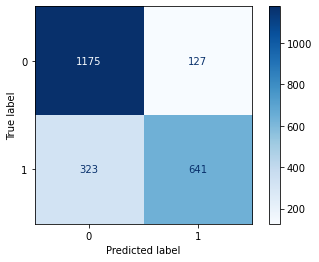

In [58]:
plot_confusion_matrix(clf_lr_tfidf, X_test_tf, y_test, cmap='Blues')

In [59]:
clf_lr_tfidf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [60]:
params_lr = {'C': (0.5, 1.0, 1.5, 2.0)}

In [61]:
clf_lr_cv = GridSearchCV(clf_lr, param_grid = params_lr, cv=5, n_jobs=-1)

In [62]:
clf_lr_cv.fit(X_train_tf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': (0.5, 1.0, 1.5, 2.0)})

In [63]:
clf_lr_cv.best_params_

{'C': 2.0}

In [64]:
clf_lr_best = LogisticRegression(C=2.0)

In [65]:
clf_lr_best.fit(X_train_tf, y_train)
clf_lr_best.predict(X_test_tf)

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [66]:
print("train accuracy:", clf_lr_best.score(X_train_tf, y_train), "\n", "test accuracy:", clf_lr_best.score(X_test_tf, y_test))

train accuracy: 0.889120151371807 
 test accuracy: 0.8031774051191527


In [67]:
np.mean(y_test == clf_lr_best.predict(X_test_tf))

0.8031774051191527

# Conclusions

The train and test accuracy, as well as accuracy and recall scores imply that the best performing model is the Naive Bayes Model, followed by SVM, and then logistic regression.